In [1]:
import xarray as xr
import uxarray as ux
import numpy as np
from tqdm.notebook import tqdm
from dask.distributed import Client, LocalCluster
import huracanpy
import pandas as pd

from tcpyPI import pi

import intake
from easygems import healpix as egh

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

import healpy as hp

In [2]:
#WARNING! some models have 3D only when called with different keys!
sim_name = "icon_d3hp003"
zoom_level = 7
time_res=6
out_dir = "/work/bb1153/b383007/hk25-hamburg/out_data/"
complete_fields = False

if complete_fields:
    out_dir = out_dir + "complete_fields/"
else:
    out_dir = out_dir + "only_tracks/"

In [3]:
n_workers=16
n_cpu=16
memory_limit="50GB"
processes=True

cluster = LocalCluster(n_workers=n_workers, 
                       threads_per_worker=n_cpu // n_workers,
                       memory_limit=memory_limit,
                       processes=processes,
                       dashboard_address=46861)
client = Client(cluster)

In [4]:
current_location = "online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
list(cat.keys())

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

In [5]:
if "um_" in sim_name:
    ds2d = cat[sim_name](zoom=zoom_level).to_dask()

    vnames = {"sst":"ts", "psl":"psl", "t":"ta", "q":"hus"}

    ds3d = cat[sim_name](zoom=zoom_level, time="PT3H").to_dask()
    
    dim="pressure"
    
if "icon_" in sim_name:
    ds2d = cat[sim_name](zoom=zoom_level, time='PT6H', time_method='inst').to_dask()
    
    vnames = {"sst":"ts", "psl":"psl", "t":"ta", "q":"hus"}

    ds3d = ds2d.copy()

    dim="pressure"
    ds3d = ds3d.assign_coords(pressure=ds3d[dim]/100)
if "ifs_" in sim_name:
    ds2d = cat[sim_name](zoom=zoom_level, dim="2D").to_dask()
    
    vnames = {"sst":"sst", "psl":"msl", "t":"t", "q":"q"}

    ds3d = cat[sim_name](zoom=zoom_level, dim="3D").to_dask()

    dim="level"

ds3d = ds3d.sortby(dim, ascending=False)
time= ds2d.time.where(ds2d.time.dt.hour % time_res == 0, drop=True)

ds2d = ds2d.chunk(chunks={'time':len(time), 'cell':2048})
ds3d = ds3d.chunk(chunks={'time':len(time), 'cell':2048})

ds2d = ux.UxDataset.from_healpix(ds2d)
ds3d = ux.UxDataset.from_healpix(ds3d)

ts = ds2d[vnames["sst"]]
psl = ds2d[vnames["psl"]]
t = ds3d[vnames["t"]]
q = ds3d[vnames["q"]]

In [6]:
p=ds3d[dim]
CKCD=0.9

def get_pi(ts, psl, p, t, q):
    #result = pi(ts, psl, p, t, q, 
    #            kwargs=dict(CKCD=CKCD, ascent_flag=0, 
    #                        diss_flag=1, ptop=50, miss_handle=1))
    result = xr.apply_ufunc(
        pi,
        ts, psl, p, t, q,
        kwargs=dict(CKCD=CKCD, ascent_flag=0, diss_flag=1, ptop=50, 
                    miss_handle=1),
        input_core_dims=[
            [], [], [dim, ], [dim, ], [dim, ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True,
        output_dtypes=[ts.dtype, ts.dtype, ts.dtype, ts.dtype, ts.dtype],
    )
    vmax, pmin, ifl, t0, otl = result
    return vmax, pmin, t0, otl, ts

#allows to save uxgrid
def sanitize_attrs(ds):
    """Convert boolean attributes to int or str for NetCDF compatibility."""
    new_attrs = {}
    for k, v in ds.attrs.items():
        if isinstance(v, (bool, np.bool_)):
            new_attrs[k] = int(v)  # or str(v)
        else:
            new_attrs[k] = v
    ds.attrs = new_attrs
    return ds

In [7]:
nside = ds3d.crs.healpix_nside
#if ("icon_" in sim_name) or ("um_" in sim_name):
ddeg = 0.2
lon = np.arange(0, 360, ddeg)
#lat = np.arange(90, -90+ddeg, -ddeg)
lat = np.arange(60, -60+ddeg, -ddeg)
#else:
#    lat = np.sort(ds3d.lat)
#    lat = lat[(lat<=60) & (lat>=-60)]
#    lon = np.sort(ds3d.lon)
pix = xr.DataArray(
    hp.ang2pix(nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)),
    )

#time = ds.time[::time_res]

#npix = ds.sizes['cell']

# Get pixel indices
#pix = np.arange(npix)

# Convert pixel indices to angular coordinates
#theta, phi = hp.pix2ang(nside, pix, nest=False)  # use nest=True if needed

# Convert to latitude and longitude
#lat = np.degrees(0.5 * np.pi - theta)  # colatitude to latitude
#lon = np.degrees(phi)

# Compute only along tracks

/home/b/b383007/.conda/envs/hk25/lib/python3.12/site-packages/huracanpy/plot/_tracks.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


(<Figure size 1000x1000 with 1 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

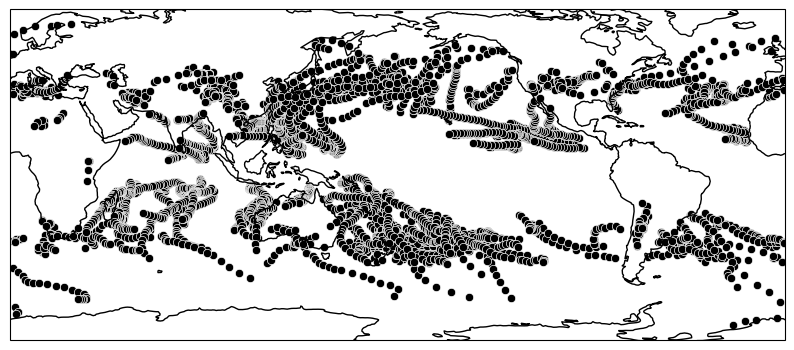

In [8]:
if not "icon_" in sim_name:
    ftrack = f"../TC_tracks/{sim_name}.csv"
else:
    ftrack = f"../TC_tracks/2D/{sim_name}.csv"
if "ifs_" in sim_name:
    ts = ts.drop_vars(["lat", "lon"])
    psl = psl.drop_vars(["lat", "lon"])
    t = t.drop_vars(["lat", "lon"])
    q = q.drop_vars(["lat", "lon"])
tracks = huracanpy.load(ftrack)
tracks.hrcn.plot_tracks()

In [ ]:
margin_deg = 8
if not complete_fields:
    for tid in tqdm(np.unique(tracks.track_id), desc="Tracks", position=0):
        track = tracks.where(tracks.track_id==tid, drop=True)

        time_track = track['time']
        time_res = pd.to_timedelta(time_track[1].values - time_track[0].values)
        start = pd.Timestamp(time_track[0].values) - pd.Timedelta(days=3)
        end   = pd.Timestamp(time_track[-1].values) + pd.Timedelta(days=3)
        time_track = pd.date_range(start, end, freq=time_res)
        time_track = np.clip(time_track, ds2d.time.values[0], ds2d.time.values[-1])
    
        ####TODO: FIX LON LAT DEFINITION IN ICON (DEFINED FROM -180:180)
        
        # Select data window
        # ts_tid = ts.sel(time=time_track).load()[:,pix]
        # psl_tid = psl.sel(time=time_track).load()[:,pix]
        # t_tid = t.sel(time=time_track).load()[...,pix]
        # q_tid = q.sel(time=time_track).load()[...,pix]

        # mask = (ts_tid.lat >= lat_slice.start) & (ts_tid.lat <= lat_slice.stop) & \
        #        (ts_tid.lon >= lon_slice.start) & (ts_tid.lon <= lon_slice.stop)

        # ts_tid = ts_tid.where(mask, drop=True) - 273.15
        # psl_tid = psl_tid.where(mask, drop=True) /100
        # t_tid = t_tid.where(mask, drop=True) - 273.15
        # q_tid = q_tid.where(mask, drop=True) * 1000

        #loop over distinct points on the track
        for i in tqdm(range(len(track['time'])), desc="Position on track", position=1, leave=False):
            lat_track = track['lat'][i]
            lon_track = track['lon'][i]
            
            min_lat = float(lat_track) - margin_deg
            max_lat = float(lat_track) + margin_deg
            min_lon = float(lon_track) - margin_deg
            max_lon = float(lon_track) + margin_deg
        
            lat_slice  = (min_lat, max_lat)
            lon_slice  = (min_lon, max_lon)

            if "icon_" in sim_name:
                lat_slice  = (min_lat, max_lat)
                lon_slice  = (min_lon-180, max_lon-180)
    
            #lat_domain = lat[(lat >= lat_slice[0]) & (lat <= lat_slice[-1])]
            #lon_domain = lon[(lon >= lon_slice[0]) & (lon <= lon_slice[-1])]

            grid = ts.sel(time=time_track[i]).subset.bounding_box(lon_slice, lat_slice).uxgrid
            path_grid = out_dir+f'{sim_name}_pi_track_{tid:04d}_pos_{i:04d}_grid'+'.nc'
            grid = sanitize_attrs(grid.to_xarray())
            grid.to_netcdf(path_grid)

            #shape_2D = (len(time_track), len(lat_domain), len(lon_domain))
            #shape_3D = (len(time_track), len(p), len(lat_domain), len(lon_domain))
            #mesh_dim = grid.face_node_connectivity.dims[0]
            #shape_2D = (len(time_track), grid._ds.dims[mesh_dim])
            #shape_3D = (len(time_track), grid._ds.dims[mesh_dim])
            #empty_arr_2D = np.full(shape_2D, np.nan, dtype=np.float32)
            #empty_arr_3D = np.full(shape_3D, np.nan, dtype=np.float32)
            #dims_1D = ["time"]
            #dims_2D = ["time", "lat", "lon"]
            #dims_3D = ["time", "z", "lat", "lon"]
            #dims_2D = ["time", mesh_dim]

            
           #  out_ds = xr.Dataset({
           #          'vmax': (dims_2D, empty_arr_2D.copy()), 
           #          'pmin': (dims_2D, empty_arr_2D.copy()),
           #     #     'ifl': (dims, empty_arr),
           #          't0': (dims_2D, empty_arr_2D.copy()),
           #          'otl': (dims_2D, empty_arr_2D.copy()),
           #          'sst': (dims_2D, empty_arr_2D.copy()),
           #     #     'sfcwind_max' : (dims_1D, track.sfcwind_max.values),
           #     #     'wind_max_925': (dims_1D, track.wind_max_925.values),
           #     #     'wind_max_850': (dims_1D, track.wind_max_850.values)
           #     #     't': (dims, empty_arr),
           #     #     'q': (dims, empty_arr),
           #     #     'msl': (dims, empty_arr),
           #          },
           #          coords={
           #          "track_id": [tid],
           #          "time": time_track,
           #          "mesh_dim" : grid._ds[mesh_dim]}
           # #         "lat": lat_domain,
           # #         "lon": lon_domain}
           #  )
            

            futures = []
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', 'Sending large graph of size', UserWarning)
                for ti in time_track:
                    #vmax, pmin, t0, otl = get_pi(ts_tid[0], psl_tid[0], p, t_tid[0], q_tid[0])

                    ts_tid = ts.sel(time=ti).subset.bounding_box(lon_slice, lat_slice).load()
                    psl_tid = psl.sel(time=ti).subset.bounding_box(lon_slice, lat_slice).load()
                    t_tid = t.sel(time=ti).subset.bounding_box(lon_slice, lat_slice).load()
                    q_tid = q.sel(time=ti).subset.bounding_box(lon_slice, lat_slice).load()
                    
                    futures.append(client.submit(get_pi, 
                                                 ts_tid -273.15, 
                                                 psl_tid /100, p, 
                                                 t_tid - 273.15, 
                                                 q_tid * 1000))
            results = client.gather(futures)
    
            # out_ds["vmax"][i] = ux.UxDataArray(vmax, uxgrid=grid)
            # out_ds["pmin"][i] = ux.UxDataArray(pmin, uxgrid=grid)
            # out_ds["t0"][i] = ux.UxDataArray(t0, uxgrid=grid)
            # out_ds["otl"][i] = ux.UxDataArray(otl, uxgrid=grid)
            # out_ds["sst"][i] = ux.UxDataArray(ts_tid[i], uxgrid=grid)
            
            out_ds = xr.Dataset()
            out_ds["vmax"] = xr.concat([item[0] for item in results], dim="time")
            out_ds["pmin"] = xr.concat([item[1] for item in results], dim="time")
            out_ds["t0"]   = xr.concat([item[2] for item in results], dim="time")
            out_ds["otl"]  = xr.concat([item[3] for item in results], dim="time")
            out_ds["sst"]  = xr.concat([item[4] for item in results], dim="time")

            # add names and units to the structure
            out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
            out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
            #out_ds.ifl.attrs['standard_name']='pyPI Flag'
            out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
            out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

            out_ds["track_id"] = tid

            path = out_dir+f'{sim_name}_pi_track_{tid:04d}_pos_{i:04d}'+'.nc'
            out_ds.to_netcdf(path)
            del out_ds, futures

Tracks:   0%|          | 0/191 [00:00<?, ?it/s]

Position on track:   0%|          | 0/11 [00:00<?, ?it/s]

# Compute everywhere

In [ ]:
chunk_size = len(ds3d.n_face)//n_workers
chunks = [slice(i, i + chunk_size) for i in range(0, len(ds3d.n_face), chunk_size)]
for i in tqdm(range(len(time)), desc="Time", position=0):
    ti = time[i]
    futures = []
    for chunk in tqdm(chunks, desc="Chunks", position=1, leave=False):
        ts_cti = ts.sel(time=ti).sel(n_face=chunk).load() - 273.15
        psl_cti = psl.sel(time=ti).sel(n_face=chunk).load() / 100
        t_cti = t.sel(time=ti).sel(n_face=chunk).load() - 273.15
        q_cti = q.sel(time=ti).sel(n_face=chunk).load() *1000

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', 'Sending large graph of size', UserWarning)
            futures.append(client.submit(get_pi, 
                                         ts_cti, 
                                         psl_cti, 
                                         p, 
                                         t_cti, 
                                         q_cti))
        
    results = client.gather(futures)
    
    out_ds = xr.Dataset()

    out_ds["vmax"] = xr.concat([item[0] for item in results], dim="n_face")
    out_ds["pmin"] = xr.concat([item[1] for item in results], dim="n_face")
    out_ds["t0"]   = xr.concat([item[2] for item in results], dim="n_face")
    out_ds["otl"]  = xr.concat([item[3] for item in results], dim="n_face")
    out_ds["sst"]  = xr.concat([item[4] for item in results], dim="n_face")
    
    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    #out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'
    out_ds.sst.attrs['standard_name'],out_ds.sst.attrs['units']='Sea surface temperature','K'

    
    #results = [xr.concat(results[i], dim="lat") for i in range(len(out_ds))]
    
#    out_ds['vmax'][dict(time=time)]  = results[0]
#    out_ds['pmin'][dict(time=time)]  = results[1]
#    out_ds['ifl'][dict(time=time)]  = results[2]
#    out_ds['t0'][dict(time=time)]  = results[3]
#    out_ds['otl'][dict(time=time)]  = results[4]

    #for key in list(out_ds.keys()):
    out_ds.to_netcdf(out_dir+f'{sim_name}_pi_{ti.values}'+'.nc')

#    vmax, pmin, ifl, t0, otl = result
#    out_ds["vmax"][time] = vmax
#    out_ds["pmin"][time] = vmax
#    out_ds["ifl"][time] = vmax
#    out_ds["t0"][time] = vmax
#    out_ds["otl"][time] = vmax

Time:   0%|          | 0/1700 [00:00<?, ?it/s]

Chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Chunks:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
def process_chunk(ts, psl, p, t, q):
    return get_pi(ts, psl, p, t, q)

chunk_size = 25  # Adjust based on available memory or number of workers
lat_chunks = [slice(i, i + chunk_size) for i in range(0, len(lat), chunk_size)]
for ti in tqdm(range(len(time))):
    ts_ti = ts.sel(time=time[ti]).load()[pix] - 273.15
    psl_ti = psl.sel(time=time[ti]).load()[pix] / 100
    t_ti = t.sel(time=time[ti]).load()[:, pix] - 273.15
    q_ti = q.sel(time=time[ti]).load()[:, pix] * 1000
#    if "icon_" in sim_name:
#        psl_i = psl_i/100
    
    futures = []
    for chunk in lat_chunks:
        ts_cti = ts_ti.isel(lat=chunk)
        psl_cti = psl_ti.isel(lat=chunk)
        t_cti = t_ti.isel(lat=chunk)
        q_cti = q_ti.isel(lat=chunk)

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', 'Sending large graph of size', UserWarning)
            futures.append(client.submit(process_chunk, ts_cti, psl_cti, p, t_cti, q_cti))
        
    results = np.array(client.gather(futures), dtype=object)

    # Initialize with empty (NaN) arrays for each variable
    shape = (1, len(lat), len(lon))
    empty_arr = np.full(shape, np.nan, dtype=np.float32)
    dims = ["time", "lat", "lon"]
    
    out_ds = xr.Dataset({
            'vmax': (dims, empty_arr.copy()), 
            'pmin': (dims, empty_arr.copy()),
       #     'ifl': (dims, empty_arr),
            't0': (dims, empty_arr.copy()),
            'otl': (dims, empty_arr.copy()),
       #     'sst': (dims, empty_arr),
       #     't': (dims, empty_arr),
       #     'q': (dims, empty_arr),
       #     'msl': (dims, empty_arr),
            },
            coords={
            "time": [time[ti].values],
            "lat": lat,
            "lon": lon}
    )
    
    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    #out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

    out_ds["vmax"].loc[dict(time=time[ti])] = xr.concat(results[:,0], dim="lat").values
    out_ds["pmin"][0, :, :] = xr.concat(results[:,1], dim="lat").values
    out_ds["t0"]  [0, :, :] = xr.concat(results[:,2], dim="lat").values
    out_ds["otl"] [0, :, :] = xr.concat(results[:,3], dim="lat").values
    #results = [xr.concat(results[i], dim="lat") for i in range(len(out_ds))]
    
#    out_ds['vmax'][dict(time=time)]  = results[0]
#    out_ds['pmin'][dict(time=time)]  = results[1]
#    out_ds['ifl'][dict(time=time)]  = results[2]
#    out_ds['t0'][dict(time=time)]  = results[3]
#    out_ds['otl'][dict(time=time)]  = results[4]

    #for key in list(out_ds.keys()):
    out_ds.to_netcdf(out_dir+f'{sim_name}_pi_{time[ti].values}'+'.nc')

#    vmax, pmin, ifl, t0, otl = result
#    out_ds["vmax"][time] = vmax
#    out_ds["pmin"][time] = vmax
#    out_ds["ifl"][time] = vmax
#    out_ds["t0"][time] = vmax
#    out_ds["otl"][time] = vmax